# Web scraping da Zalando

Si vuole fare web scraping dal sito zalando in modo tale da ottenere informazioni sugli zaini per notebook

### Librerie

In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup 
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
page_url = "https://www.zalando.it/catalogo/?q=zaino+notebook"

### Estrazione automatica

In [3]:
def scrape_page(page_url , records = None):
    if records is None:
        records = []

    page_html = urlopen(page_url).read()
    containers = soup(page_html).findAll('div' , { 'class' : '_5qdMrS w8MdNG cYylcv BaerYO _75qWlu iOzucJ JT3_zV _Qe9k6'})

    for container in containers :
        try:
            marca =  container.findAll('h3' , { 'class'  : 'FtrEr_ lystZ1 FxZV-M HlZ_Tf ZkIJC- r9BRio qXofat EKabf7 nBq1-s _2MyPg2'})[0].text
        except:
            marca= ''
        try:
            modello = container.findAll('h3' , { 'class'  : 'sDq_FX lystZ1 FxZV-M HlZ_Tf ZkIJC- r9BRio qXofat EKabf7 nBq1-s _2MyPg2'})[0].text
        except :
            modello = ''
        try:
            prezzo = container.findAll('span', {'class': 'sDq_FX lystZ1 FxZV-M HlZ_Tf'})[0].text
        except:
            try:
                prezzo_text = container.findAll('span', {'class': 'sDq_FX lystZ1 dgII7d Km7l2y'})[0].text
                prezzo = prezzo_text.replace('€', '').replace(',', '.')
            except:
                prezzo = 0.0
        try:
            sconto = container.findAll('span' , { 'class'  : 'sDq_FX goVnUa FxZV-M Km7l2y r9BRio' })[0].text
            if sconto.startswith('Fino a ') : sconto = sconto.replace('Fino a ',' ')
            if sconto.startswith(' ') : sconto = sconto.replace(' ','')
        except:
            sconto = "no"

        try :  
            link = container.findAll('a')[0]['href']
        except:
            link = ''
        try :
            img_url = container.findAll('img', {'class': 'sDq_FX lystZ1 FxZV-M _2Pvyxl JT3_zV EKabf7 mo6ZnF _1RurXL mo6ZnF _7ZONEy'})[0]['src']
        except :
            image_url = ''
            
        records.append([marca, modello, prezzo, sconto, link, img_url])

    return records

### Navigazione tra le pagine

In [4]:
def navigate_and_scrape(base_url, records = None):
    if records is None:
        records = []
    
    all_records = records
    page = 1 
    limit = 2
    while(page <= limit):
        url = f"{base_url}{page:d}"
        records = scrape_page(url)
        all_records.extend(records)
        if len(records) == 0 : 
            break
        page += 1
    
    return all_records

In [5]:
base_url = "https://www.zalando.it/donna/?q=zaino+notebook&p="
records = navigate_and_scrape(base_url) 

data = pd.DataFrame(records, columns=['marca','modello','prezzo','sconto','link','img_url'])
data = data.loc[data['prezzo'].str.contains('€') == False]
data['prezzo'] = data['prezzo'].astype(float)

data.head()

,marca,modello,prezzo,sconto,link,img_url
0,Anna Field,AWH-E754 / 502 - BLUE - Borsa porta PC - black,24.89,-25%,https://www.zalando.it/anna-field-borsa-porta-...,https://img01.ztat.net/article/spp-media-p1/77...
1,PARFOIS,BRIEFCASE AUBREY - Borsa porta PC - black,25.49,-45%,https://www.zalando.it/parfois-briefcase-aubre...,https://img01.ztat.net/article/spp-media-p1/50...
2,Vans,VANS PADDED LAPTOP SLEEVE - Borsa porta PC - b...,16.95,-23%,https://www.zalando.it/vans-sleeve-borsa-porta...,https://img01.ztat.net/article/spp-media-p1/a4...
3,Pier One,LEATHER UNISEX - Borsa porta PC - brown,57.99,-11%,https://www.zalando.it/pier-one-unisex-ventiqu...,https://img01.ztat.net/article/spp-media-p1/e6...
6,Vans,VANS PADDED LAPTOP SLEEVE - Borsa porta PC - b...,14.95,-32%,https://www.zalando.it/vans-sleeve-borsa-porta...,https://img01.ztat.net/article/spp-media-p1/8a...


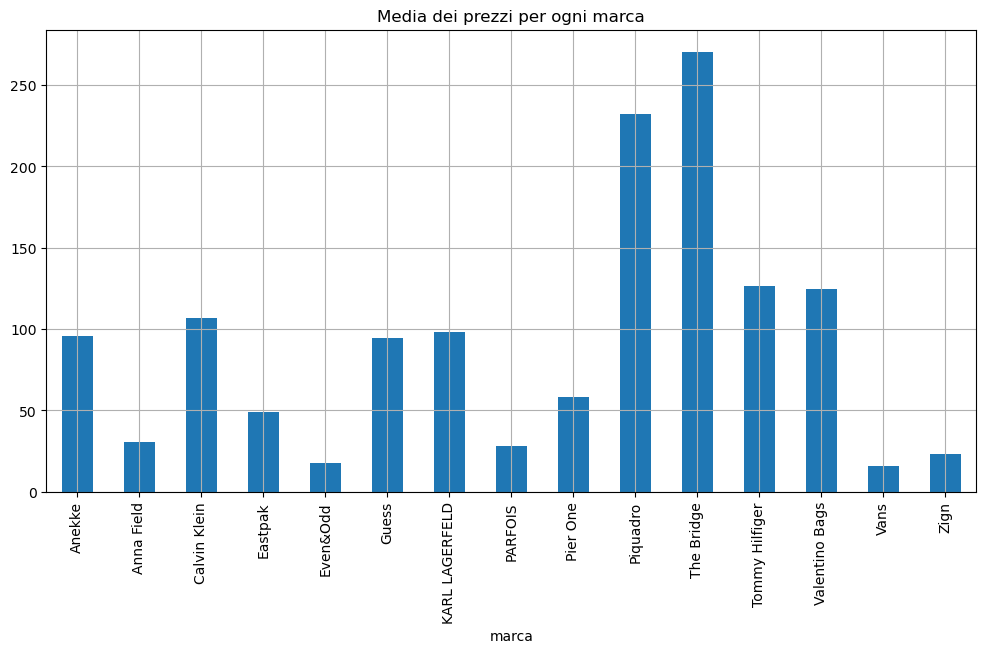

In [6]:
data.head()

# Ora puoi calcolare la media dei prezzi
plt.figure(figsize=(12, 6))
data.groupby('marca')['prezzo'].mean().plot.bar()
plt.title("Media dei prezzi per ogni marca")
plt.grid()
plt.show()

### Invio sconti su Telegram

In [7]:
discounted = data[data['sconto'] != "no"]
print(discounted)

bot_token = "6437206678:AAE5BNE3ierHYDIz1hxtjnS_k4nSt0SwqTA"
chat_id = "-4008691980"

for _, row in discounted.iterrows():
    message_text = f'*{row["marca"]}*\n*Modello*: {row["modello"]}\n*Prezzo*: {row["prezzo"]} {row["sconto"]}\n[Visita il Prodotto]({row["link"]})'
    message_text = requests.utils.quote(message_text)
    url = f'https://api.telegram.org/bot6437206678:AAE5BNE3ierHYDIz1hxtjnS_k4nSt0SwqTA/sendMediaGroup'
    data = {
        'chat_id': -4008691980,
        'media': [
            {'caption': message_text, 'parse_mode': 'HTML'},
        ],
    }    
    requests.post(url, json=data)

             marca                                            modello  prezzo  \
0       Anna Field     AWH-E754 / 502 - BLUE - Borsa porta PC - black   24.89   
1          PARFOIS         BRIEFCASE AUBREY  - Borsa porta PC - black   25.49   
2             Vans  VANS PADDED LAPTOP SLEEVE - Borsa porta PC - b...   16.95   
3         Pier One            LEATHER UNISEX - Borsa porta PC - brown   57.99   
6             Vans  VANS PADDED LAPTOP SLEEVE - Borsa porta PC - b...   14.95   
7       Anna Field                              Borsa porta PC - grey   26.49   
8       Anna Field                             Borsa porta PC - black   36.99   
9   Tommy Hilfiger  ESSENTIAL COMPUTER BAG UNISEX - Ventiquattrore...   89.99   
10        Even&Odd                             Borsa porta PC - black   18.09   
11      Anna Field                             Borsa porta PC - black   29.39   
13           Guess   VEZZOLA DOC CASE UNISEX - Ventiquattrore - beige   90.99   
14      Anna Field          

In [ ]:
discounted = data
print(discounted)

bot_token = "6437206678:AAE5BNE3ierHYDIz1hxtjnS_k4nSt0SwqTA"
chat_id = "-4008691980"

for _, row in range len(data):
    message_text = f'*{row["marca"]}*\n*Modello*: {row["modello"]}\n*Prezzo*: {row["prezzo"]} {row["sconto"]}\n[Visita il Prodotto]({row["link"]})'
    message_text = requests.utils.quote(message_text)
    url = f'https://api.telegram.org/bot6437206678:AAE5BNE3ierHYDIz1hxtjnS_k4nSt0SwqTA/sendMediaGroup'
    data = {
        'chat_id': -4008691980,
        'media': [
            {'caption': message_text, 'parse_mode': 'HTML'},
        ],
    }    
    requests.post(url, json=data)